In [21]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import random
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from collections import Counter

from peerselect import impartial
from peerselect import profile_generator

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 14}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3)
np.set_printoptions(threshold=10)
#np.set_printoptions(threshold=np.inf)

In [22]:
_DEBUG = False

#random.seed(15)

class Impartial:
    VANILLA = "Vanilla"
    EXACT = "ExactDollarPartition"
    PARTITION = "Partition"
    DPR = "DollarPartitionRaffle"
    CREDIABLE = "CredibleSubset"
    RAFFLE = "DollarRaffle"
    NOMINATION = "PeerNomination"
    ALL = (VANILLA, EXACT, PARTITION, RAFFLE, CREDIABLE, DPR, NOMINATION)

s = 20
test_n = [120]
test_k = [15, 20, 25, 30, 35]
test_m = [10]
test_l = [5]
test_p = [0.5]

# Map for all Results.
v_results = {}
gt_results = {}
for n,k,m,l,p in itertools.product(test_n, test_k, test_m, test_l, test_p):
    agents = np.arange(0, n)
    for c_sample in range(s):
        # Generate a profile and clustering
        profile = profile_generator.generate_mallows_mixture_profile(agents, agents, [1.0], [agents], [p])
        clustering = impartial.even_partition_order(sorted(agents, key=lambda j: random.random()), l)
        
        # Uncomment one:
        #TODO: check to see how many reviews each person is getting -- is it always off?
        # Borda
        scores = np.arange(m-1, -1, -1)
        #Lexicographic
        #scores = [pow(n, i) for i in np.arange(m, 0, -1)]
        
        # Generate an m-regular assignment
        m_assignment = profile_generator.generate_approx_m_regular_assignment(agents, m, clustering, randomize=True)
        score_matrix = profile_generator.strict_m_score_matrix(profile, m_assignment, scores)

        #Compute Target Set.
        target_set = impartial.vanilla(score_matrix, k)
        
        # Capture the winning sets
        ws = {}
        # Let everyone else have the same size set so they are all compareable.
        vs = [i for i,j in target_set]
        ws[Impartial.VANILLA] = vs
        
        # Set all sizes to be the same.
        ws[Impartial.EXACT] = impartial.exact_dollar_partition_explicit(score_matrix, k, clustering, normalize=True)
        ws[Impartial.PARTITION] = impartial.partition_explicit(score_matrix, k, clustering, normalize=False)
        
        ws[Impartial.CREDIABLE] = impartial.credible_subset(score_matrix, k, m, normalize=False)
        ws[Impartial.DPR] = impartial.dollar_raffle_explicit(score_matrix, k, clustering, normalize=True)
        #Call Raffle and have everyone in a cluster by themselves = Dollar.
        ws[Impartial.RAFFLE] = impartial.dollar_raffle(score_matrix, k, n, randomize=True, normalize=True)
        
        # See if peer nomination works..
        ws[Impartial.NOMINATION] = impartial.peer_nomination_lottery(score_matrix, k, 0.01)
        print(len(ws[Impartial.NOMINATION]))
        
        for x in Impartial.ALL:
            key = (n, k, m, l, p, s, x)
            v_results[key] = v_results.get(key, []) + [len(set(vs) & set(ws[x]))]
            gt_results[key] = gt_results.get(key, []) + [len(set(np.arange(0, k)) & set(ws[x]))]
            #if x == Impartial.VANILLA:
            #    print(ws[x])

    print("Finished: " + ",".join([str(x) for x in [n, k, m, l, p, s]]))
    
v_df = pd.DataFrame(v_results)
v_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

gt_df = pd.DataFrame(gt_results)
gt_df.columns.names = ['n', 'k', 'm', 'l', 'p', 's', 'algo']

17
15
15
13
14
15
14
15
16
19
16
17
15
16
17
17
18
13
15
15
Finished: 120,15,10,5,0.5,20
19
20
20
21
23
20
19
20
24
19
21
20
23
21
22
19
20
19
23
16
Finished: 120,20,10,5,0.5,20
25
23
25
23
27
25
23
25
24
27
25
27
27
29
24
24
27
27
29
28
Finished: 120,25,10,5,0.5,20
30
28
33
29
35
28
35
28
31
29
29
32
31
31
31
27
31
34
29
31
Finished: 120,30,10,5,0.5,20
34
36
33
33
35
36
32
38
35
34
36
38
34
38
35
35
36
35
33
32
Finished: 120,35,10,5,0.5,20


		Approximate Vanilla Ordering
		 MEAN:
algo                Vanilla  ExactDollarPartition  Partition  PercentChange
n   k  m  l p   s                                                          
120 15 10 5 0.5 20    12.85                 11.80      11.65       1.287554
    20 10 5 0.5 20    18.05                 16.15      15.85       1.892744
    25 10 5 0.5 20    22.55                 21.40      21.15       1.182033
    30 10 5 0.5 20    26.80                 26.10      25.60       1.953125
    35 10 5 0.5 20    31.70                 30.50      29.65       2.866779
		 STD:
algo                 Vanilla  ExactDollarPartition  Partition  PercentChange
n   k  m  l p   s                                                           
120 15 10 5 0.5 20  0.875094              1.105013   1.386969     -20.328994
    20 10 5 0.5 20  0.944513              1.136708   1.268028     -10.356224
    25 10 5 0.5 20  1.145931              1.095445   1.308877     -16.306462
    30 10 5 0.5 20  1.196486       

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


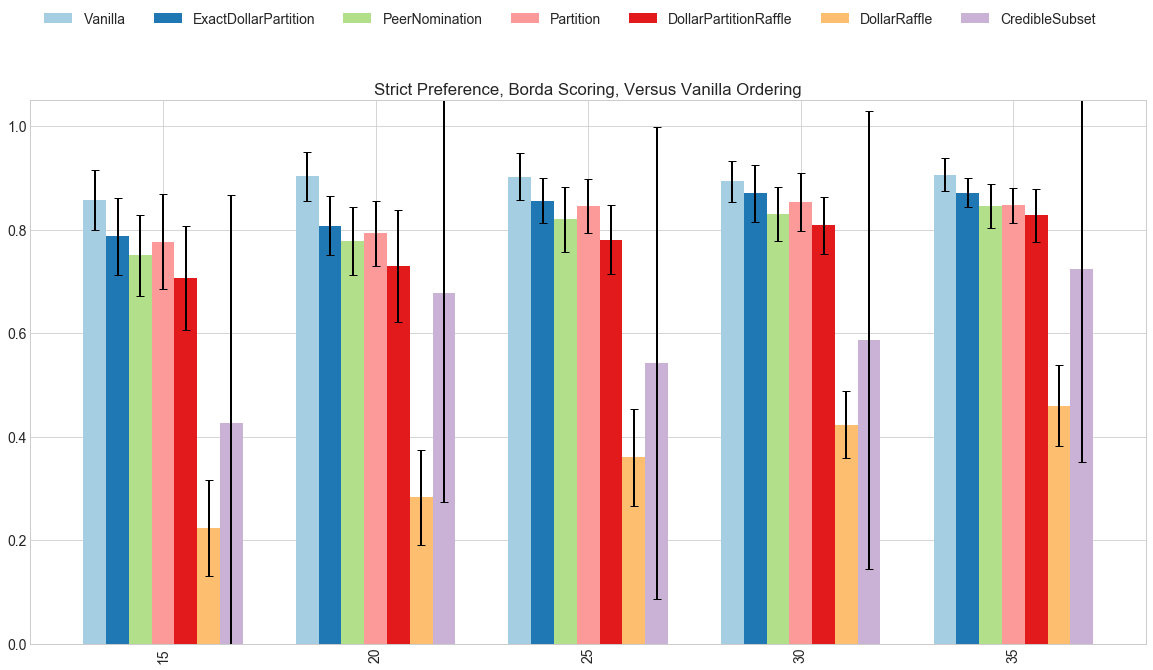

In [25]:
#
# Takes a slice of the array and generates the graphs etc.
#
def make_output(df, test, labels):
    means = df.loc[:, test].mean().unstack()
    errors = df.loc[:, test].std().unstack()
    mins = df.loc[:, test].min().unstack()
    # print(means)
    # print(errors)

    print("\t\tApproximate Vanilla Ordering")
    means = means[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    errors = errors[['Vanilla','ExactDollarPartition', "PeerNomination", 'Partition', 'DollarPartitionRaffle', 'DollarRaffle', 'CredibleSubset']]
    
    means['PercentChange'] = (means.ExactDollarPartition - means.Partition) / means.Partition * 100.
    errors['PercentChange'] = (errors.ExactDollarPartition - errors.Partition) / errors.Partition * 100.
    mins['PercentChange'] = (mins.ExactDollarPartition - mins.Partition) / mins.Partition * 100.
    print("\t\t MEAN:\n" + str(means[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    print("\t\t STD:\n" + str(errors[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    print("\t\t MIN:\n" + str(mins[['Vanilla','ExactDollarPartition', 'Partition', 'PercentChange']]))
    del means['PercentChange']
    del errors['PercentChange']
    del mins['PercentChange']
    
    for index, row in means.iterrows():
        means.ix[index] = row / float(index[1])
    for index, row in errors.iterrows():
        errors.ix[index] = row / float(index[1])
    
    # print(errors)
    
    #Set colors..
    color_list = plt.cm.Paired(np.linspace(0, 1, 10))
    color_list = color_list[:7]
    #color_list = sns.color_palette("pastel", 6)
    means.plot(kind='bar', legend=False, yerr=errors.values.T, figsize=(20, 10), ylim=(0.0, 1.05), \
            color=color_list, error_kw={'ecolor':'Black', 'linewidth':2, 'capsize':4}, width=0.75)
    plt.title("Strict Preference, Borda Scoring, Versus Vanilla Ordering")
    plt.legend(bbox_to_anchor = (0,0.01,1,1), bbox_transform=plt.gcf().transFigure, loc='upper center', ncol=7, borderaxespad=0.)
    plt.gca().set_xticklabels(labels)
    plt.gca().set_xlabel("")
    plt.show()
make_output(gt_df, (120,slice(None),10,5,0.5,20), test_k)

In [5]:
(gt_df[(120,25,10,5,0.0,1)]/25).mean()

algo
Vanilla                  0.96
ExactDollarPartition     0.88
Partition                0.88
DollarRaffle             0.28
CredibleSubset           0.96
DollarPartitionRaffle    0.84
PeerNomination           0.92
dtype: float64

In [ ]:
a = np.array([[1, 2, 0, 0],
              [2, 1, 1, 1],
              [0, 0, 3, 0],
              [0, 0, 0, 4]])
    

In [ ]:
(a[0,:].nonzero()[0])

In [ ]:
from scipy import stats

# We assume that the score matrix is strict, i.e., there are no ties in the scores assigned.

def peer_nomination_lottery(score_matrix, k, epislon=0):
    winning_set = []
    n = score_matrix.shape[0]
    for a in range(score_matrix.shape[0]):
        print("agent",a)
        nomination_count = 0
        # Iterate over each column that has non_zero entry.
        for pool in (score_matrix[a,:].nonzero()[0]):
            # Compute the nominating fraction
            # m is the numner of non-zero entries in teh column
            m = np.count_nonzero(score_matrix[:,pool])
            nomination_fraction = (float(k) / float(n)) * m           
            print(nomination_fraction)
            print(score_matrix[:,pool])
            # ranks is densely packed and will have highest value at best scored agent.
            ranks = stats.rankdata(score_matrix[:,pool], method='dense').astype(int)
            print(ranks)
            max_rank = np.max(ranks)
            print("threshold", max_rank - np.floor(nomination_fraction))
            # The player needs to fall within ranks > max_rank - floor(nomination_quota)
            if ranks[a] > max_rank - np.floor(nomination_fraction):
                print("nominated @ 1")
                nomination_count += 1
            # Otherwise if it is in the border line rank then we nominate with the remainder.
            elif ranks[a] > (max_rank - np.floor(nomination_fraction) - 1):
                print("nominated @ remainder", nomination_fraction - np.floor(nomination_fraction))
                if np.random.uniform() < nomination_fraction - np.floor(nomination_fraction):
                    nomination_count += 1
        print("nomination_count", nomination_count)
        # If we are nominated by at least half the people who review us...
        if nomination_count >= np.floor(np.count_nonzero(score_matrix[a,:]) / 2.0):
            winning_set.append(a)
    return winning_set
        
            
                
            
            
        

peer_nomination_lottery(a, 2, 0.0)

In [ ]:
a[0].nonzero()

In [ ]:
a[:,1]

In [ ]:
np.floor(2.5)

In [ ]:
np.random.uniform()